In [1]:
!git clone https://github.com/NicolasCambon/RNN_UniversalDependencies_FR.git #Téléchargment des données

fatal: destination path 'RNN_UniversalDependencies_FR' already exists and is not an empty directory.


In [117]:
def distance_verbe(fic):
  try:
    fichier = open(fic,"r")
  except IOError:
    print("le fichier",fic, "n'existe pas")
    return None
  
  liste=[]
  for ligne in fichier :  
    ligne = ligne.strip('\n\r') 
    seq = [x for x in ligne.split()]  
    liste.append(seq)  
  fichier.close()
  
  sentence = []
  part=[]
  for l in range (len(liste)-1):
    if len(liste[l])!= 0:
      part.append(liste[l])
    else:
      sentence.append(part)
      part=[]
  num=0
  deno=0
  distance = []
  indice = []
  for i in range (len(sentence)):
    lis=[]
    figue = []
    igu = []
    for j in range(len(sentence[i])):
      if len(sentence[i][j])>7 and sentence[i][j][3] == 'VERB' and'Number'in sentence[i][j][5]:
        chiffre = sentence[i][j][0]
          
        for k in range(len(sentence[i])):
          if len(sentence[i][k])>7 and sentence[i][k][6]== chiffre and sentence[i][k][0] not in lis :
            if 'nsubj'in sentence[i][k][7] or 'conj' in sentence[i][k][7]:
              lis.append(sentence[i][k][0])
              igu.append(j-2)
              figue.append((abs(int(chiffre)- int(sentence[i][k][0])))-1)
              num += abs(int(chiffre)-int(sentence[i][k][0]))
              deno+=1
    distance.append(figue)
    indice.append(igu)
  return (num/deno,distance,indice)

moy_tr, dis_tr, ind_tr = distance_verbe('RNN_UniversalDependencies_FR/Donnees/fr_sequoia-ud-train.conllu.txt')
print(moy_tr)
moy_te, dis_te, ind_te = distance_verbe('RNN_UniversalDependencies_FR/Donnees/fr_sequoia-ud-test.conllu.txt')
print(moy_te)
         

4.54699475594998
4.480088495575221


In [118]:
maxi_tr = 0
for i in range (len(dis_tr)) :
  if len(dis_tr[i])!= 0 and max(dis_tr[i])>maxi_tr:
    maxi_tr = max(dis_tr[i])

    
maxi_te = 0
for i in range (len(dis_te)) :
  if len(dis_te[i])!= 0 and max(dis_te[i])>maxi_te:
    maxi_te = max(dis_te[i])   

maxi_tr += 1
maxi_te += 1

pin = [0] * maxi_tr
pon = [0] * maxi_te
for i in range(len(dis_tr)):
  for j in range(len(dis_tr[i])):
    pin[dis_tr[i][j]] += 1

for i in range(len(dis_te)):
  for j in range(len(dis_te[i])):
    pon[dis_te[i][j]] += 1

print(pin)
print(pon)



[761, 602, 272, 155, 114, 91, 55, 57, 49, 41, 36, 33, 28, 22, 16, 15, 19, 21, 3, 12, 11, 10, 9, 4, 4, 7, 4, 1, 1, 7, 3, 1, 0, 3, 2, 0, 2, 2, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
[129, 105, 57, 40, 23, 14, 11, 8, 12, 10, 3, 5, 2, 3, 5, 0, 3, 3, 4, 3, 2, 1, 0, 1, 1, 0, 0, 1, 0, 3, 1, 1, 0, 0, 0, 1]


In [61]:
import numpy as np

def donne(fic):
  print("lecture des donnees d'entrée depuis le fichier : ", fic) 
  try:
    fichier = open(fic,"r")
  except IOError:
    print("le fichier",fic, "n'existe pas")
    return None
  
  liste=[]
  for ligne in fichier :  
    ligne = ligne.strip('\n\r') 
    seq = [x for x in ligne.split()]  
    liste.append(seq)  
  fichier.close()
  
  sentence = []
  part=[]
  for l in range (len(liste)-1):
    if len(liste[l])!= 0:
      part.append(liste[l])
    else:
      sentence.append(part)
      part=[]

  POP=[]
  Out=[]
  for i in range(len(sentence)):  
    pa=[]
    no=[]
    if i % 2 == 0 : #i <= len(sentence)//2:
      for e in range(2,len(sentence[i])):
        flag=0
        inf=''
        nomb=''
        if sentence[i][e][3] == "AUX":
          if sentence[i][e][2] == "avoir":
            inf+='_avoir'
          else:
            inf+='_etre'

        if "Sing" in sentence[i][e][5]:
          nomb+="_S"
        elif "Plur" in sentence[i][e][5]:
          nomb+="_P"

        pa.append(sentence[i][e][3]+inf+nomb)
        if sentence[i][e][3] != "VERB":
          no.append(3)
        if sentence[i][e][3] == "VERB" and len(nomb) != 0:
          no.append(2)
        if sentence[i][e][3] == "VERB" and len(nomb) == 0:
          no.append(3)
      POP.append(pa)
      Out.append(no)
      
    else:
      for e in range(2,len(sentence[i])):
        flag=0
        inf=''
        nomb=''
        if sentence[i][e][3] == "AUX":
          if sentence[i][e][2] == "avoir":
            inf+='_avoir'
          else:
            inf+='_etre'
            
        if sentence[i][e][3] != "VERB":
          if "Sing" in sentence[i][e][5]:
            nomb+="_S"
          elif "Plur" in sentence[i][e][5]:
            nomb+="_P"
          pa.append(sentence[i][e][3]+inf+nomb)
          no.append(3)
        elif sentence[i][e][3] == "VERB":
          if "Sing" in sentence[i][e][5]:
            nomb+="_P"
          elif "Plur" in sentence[i][e][5]:
            nomb+="_S"
          pa.append(sentence[i][e][3]+inf+nomb)
          if len(nomb) != 0:
            no.append(1)
          else: #elif len(nomb) == 0:
            no.append(3)
           
      POP.append(pa)
      Out.append(no)
  return(POP,Out) 



def maximun(POP_tr,POP_te):
  maxi = len(POP_tr[0])
  for i in POP_tr:
    if len(i) > maxi:
      maxi=len(i)
  for j in POP_te:
    if len(j) > maxi:
      maxi=len(j)
  return(maxi)

def dico(POP_tr,POP_te):
  dic={}
  lis=[]
  k=1
  for i in range (len(POP_tr)):
    for j in range(len(POP_tr[i])):
      if POP_tr[i][j] not in lis:
        lis.append(POP_tr[i][j])
        dic[POP_tr[i][j]]=k
        k+=1
        
  for i in range (len(POP_te)):
    for j in range(len(POP_te[i])):
      if POP_te[i][j] not in lis:
        lis.append(POP_te[i][j])
        dic[POP_te[i][j]]=k
        k+=1  
  return(dic)

def convert(POP,dic):
  Input=[]
  for i in range (len(POP)):
    intp=[]
    for j in range(len(POP[i])):
      intp.append(dic[POP[i][j]])
    Input.append(intp)
  return(Input)


def rempli(POP_tr,POP_te,Out_tr,Out_te,maxi):
  
  for i in range (len(POP_tr)):
    if len(POP_tr[i]) < maxi:
      for k in range(maxi-len(POP_tr[i])):
        POP_tr[i].insert(0,0)
        Out_tr[i].insert(0,0)
  
  for j in range (len(POP_te)):
    if len(POP_te[j]) < maxi:
      for k in range(maxi-len(POP_te[j])):
        POP_te[j].insert(0,0)
        Out_te[j].insert(0,0)
  
  ma=[]
  for i in range (len(Out_tr)):
    lin=[]
    for j in range (len(Out_tr[i])):
      bn=[0]*4
      bn[Out_tr[i][j]]+= 1
      lin.append(bn)
    ma.append(lin)
  Out_tr = ma
  
  mi=[]
  for i in range (len(Out_te)):
    lan=[]
    for j in range (len(Out_te[i])):
      bo=[0]*4
      bo[Out_te[i][j]]+= 1
      lan.append(bo)
    mi.append(lan)
  Out_te = mi
 
  return(POP_tr,Out_tr,POP_te,Out_te)


def mise_en_forme(Inp,Out):
  
  POP_r = np.array(Inp).reshape (len(Inp),maxi)
  Out_r = np.array(Out).reshape (len(Out),maxi,4)
  
  return(POP_r,Out_r)



inp_tr,Out_tr= donne('RNN_UniversalDependencies_FR/Donnees/fr_sequoia-ud-train.conllu.txt')
inp_te,Out_te= donne('RNN_UniversalDependencies_FR/Donnees/fr_sequoia-ud-test.conllu.txt')
maxi = maximun(inp_tr,inp_te)
dictionnaire=dico(inp_tr,inp_te)

x_train = convert(inp_tr,dictionnaire)
x_test = convert(inp_te,dictionnaire)
inp_tr_r,Out_tr_r,inp_te_r,Out_te_r= rempli(x_train,x_test,Out_tr,Out_te,maxi)

x_train,y_train = mise_en_forme(inp_tr_r,Out_tr_r)
print('x shape = ', x_train.shape)
print('y shape = ', y_train.shape)

x_test,y_test = mise_en_forme(inp_te_r,Out_te_r)
print('x shape = ', x_test.shape)
print('y shape = ', y_test.shape)




lecture des donnees d'entrée depuis le fichier :  RNN_UniversalDependencies_FR/Donnees/fr_sequoia-ud-train.conllu.txt
lecture des donnees d'entrée depuis le fichier :  RNN_UniversalDependencies_FR/Donnees/fr_sequoia-ud-test.conllu.txt
x shape =  (2230, 150)
y shape =  (2230, 150, 4)
x shape =  (455, 150)
y shape =  (455, 150, 4)


In [119]:
def correct(y):
  Verbe_correct = 0
  Verbe_faux = 0
  indice_Vc=[]
  indice_Vf=[]
  for i in range (len(y)):
    ivc=[]
    ivf=[]
    for j in range(len(y[i])):
      if y[i][j][1] == 1:
        Verbe_faux += 1
        ivf.append(j)
      elif y[i][j][2] == 1:
        Verbe_correct += 1
        ivc.append(j)
    indice_Vc.append(ivc)
    indice_Vf.append(ivf)
  print(Verbe_correct)
  print(Verbe_faux)
  return (Verbe_correct,Verbe_faux,indice_Vc,indice_Vf)

nb_vc_tr, nb_vf_tr, nb_indi_vc_tr, nb_indi_vf_tr = correct(y_train)
nb_vc_te, nb_vf_te, nb_indi_vc_te, nb_indi_vf_te = correct(y_test)

1513
1557
286
276


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Embedding

def argmax (L) :
  arg = 0
  maxi = L[arg]
  i = 0
  while i < len(L) :
    if L[i] > maxi :
      arg = i
      maxi = L[i]
    i += 1
  return (arg)


def commun (x_t, i1, i2):
  l=model.predict(x_t)
  vcnp = 0
  vfnp = 0
  for i in range(len(l)):
    for j in range(len(l[i])):
      maxi = argmax(l[i][j])
      for k in range (len(i1[i])):
        if i1[i][k] == j:
          if maxi == 2:
            vcnp +=1
      for p in range (len(i2[i])):
        if i2[i][p] == j:
          if maxi == 1:
            vfnp +=1
  #print(vcnp)
  #print(vfnp)
  return(vcnp,vfnp)

def predict(x_t):
  l=model.predict(x_t)
  pv = 0
  pf = 0
  for i in range (len (l)):
    for j in range (len (l[i])):
      maxi = argmax(l[i][j])
      if maxi == 2:
        pv += 1
      elif maxi == 1:
        pf += 1
  #print(pv)
  #print(pf)
  return(pv,pf)

model = Sequential()
model.add(Embedding(1+len(list(dictionnaire.values())), 150, input_length=maxi))
model.add(LSTM(150,return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(150,return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
model.add(TimeDistributed(Dense(activation='softmax',units=4)))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

precision_faux_train = []
rappel_faux_train = []
precision_vraie_train = []
rappel_vraie_train = []

precision_faux_test = []
rappel_faux_test = []
precision_vraie_test = []
rappel_vraie_test = []

epochs = []

for i in range (1,11):
  epochs.append(i)
  model.fit(x_train,y_train,epochs=1,batch_size=5,validation_data=(x_test, y_test))
  
  vcp_tr, vfp_tr = commun(x_train, nb_indi_vc_tr, nb_indi_vf_tr )
  predic_vrai_tr ,predic_faux_tr = predict(x_train)
  precision_faux_train.append(vfp_tr/predic_faux_tr)
  rappel_faux_train.append(vfp_tr/nb_vf_tr)
  precision_vraie_train.append(vcp_tr/predic_vrai_tr)
  rappel_vraie_train.append(vcp_tr/nb_vc_tr)
  
  vcp_te, vfp_te = commun(x_test, nb_indi_vc_te, nb_indi_vf_te)
  predic_vrai_te ,predic_faux_te = predict(x_test)
  precision_faux_test.append(vfp_te/predic_faux_te)
  rappel_faux_test.append(vfp_te/nb_vf_te)
  precision_vraie_test.append(vcp_te/predic_vrai_te)
  rappel_vraie_test.append(vcp_te/nb_vc_te)
 

Using TensorFlow backend.
W0614 20:30:35.310632 139908720547712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 20:30:35.336931 139908720547712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 20:30:35.340609 139908720547712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 20:30:35.475499 139908720547712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

Train on 2230 samples, validate on 455 samples
Epoch 1/1
2230/2230 [==============================] - 170s 76ms/step - loss: 0.0697 - acc: 0.9829 - val_loss: 0.0068 - val_acc: 0.9962
Train on 2230 samples, validate on 455 samples
Epoch 1/1
2230/2230 [==============================] - 169s 76ms/step - loss: 0.0064 - acc: 0.9970 - val_loss: 0.0056 - val_acc: 0.9976
Train on 2230 samples, validate on 455 samples
Epoch 1/1
2230/2230 [==============================] - 169s 76ms/step - loss: 0.0050 - acc: 0.9979 - val_loss: 0.0036 - val_acc: 0.9989
Train on 2230 samples, validate on 455 samples
Epoch 1/1
2230/2230 [==============================] - 171s 77ms/step - loss: 0.0036 - acc: 0.9987 - val_loss: 0.0045 - val_acc: 0.9986
Train on 2230 samples, validate on 455 samples
Epoch 1/1
2230/2230 [==============================] - 170s 76ms/step - loss: 0.0030 - acc: 0.9989 - val_loss: 0.0027 - val_acc: 0.9991
Train on 2230 samples, validate on 455 samples
Epoch 1/1
2230/2230 [=================

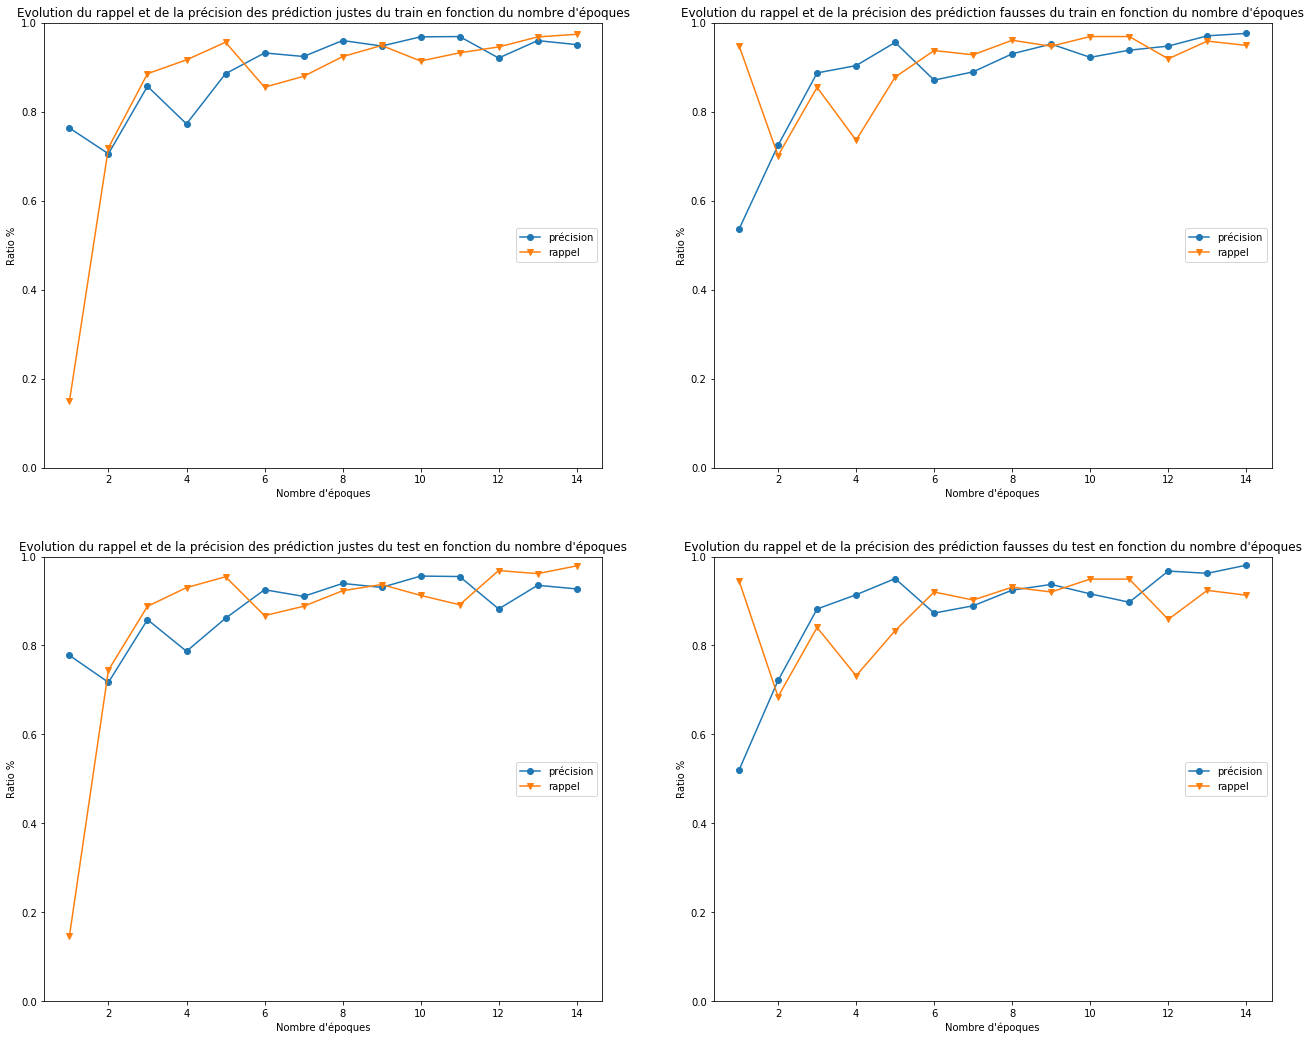

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22,18))
plt.subplot(221)
plt.plot(epochs,precision_vraie_train,marker='o',label="précision")
plt.plot(epochs,rappel_vraie_train,marker='v',label="rappel")
plt.xlabel("Nombre d'époques")
plt.ylabel('Ratio %')
plt.ylim(0,1)
plt.title("Evolution du rappel et de la précision des prédiction justes du train en fonction du nombre d'époques")
plt.legend(loc=7)

plt.subplot(222)
plt.plot(epochs,precision_faux_train,marker='o',label="précision")
plt.plot(epochs,rappel_faux_train,marker='v',label="rappel")
plt.xlabel("Nombre d'époques")
plt.ylabel('Ratio %')
plt.ylim(0,1)
plt.title("Evolution du rappel et de la précision des prédiction fausses du train en fonction du nombre d'époques")
plt.legend(loc=7)

plt.subplot(223)
plt.plot(epochs,precision_vraie_test,marker='o',label="précision")
plt.plot(epochs,rappel_vraie_test,marker='v',label="rappel")
plt.xlabel("Nombre d'époques")
plt.ylabel('Ratio %')
plt.ylim(0,1)
plt.title("Evolution du rappel et de la précision des prédiction justes du test en fonction du nombre d'époques")
plt.legend(loc=7)

plt.subplot(224)
plt.plot(epochs,precision_faux_test,marker='o',label="précision")
plt.plot(epochs,rappel_faux_test,marker='v',label="rappel")
plt.xlabel("Nombre d'époques")
plt.ylabel('Ratio %')
plt.ylim(0,1)
plt.title("Evolution du rappel et de la précision des prédiction fausses du test en fonction du nombre d'époques")
plt.legend(loc=7)
plt.show()

In [0]:
def rajout_0 (y_t,ind):
  num0_tr=[]
  for i in range(len(y_t)):
    chi = 0
    for j in range(len(y_t[i])):
      if argmax(y_t[i][j]) == 0:
        chi +=1
    num0_tr.append(chi)
  for i in range(len(ind)):
    if len(ind[i]) != 0:
      for j in range(len(ind[i])):
        ind[i][j] += num0_tr[i]
  return(ind)

ind_tr_0 = rajout_0(y_train,ind_tr) 
ind_te_0 = rajout_0(y_test,ind_te) 



In [0]:
def suj_verb_distance (entre,dis,ind,ind_vrai,ind_faux):
  l = model.predict(entre)
  di = [0]*11
  tdi = [0]*11
  di_v = [0]*11
  tdi_v = [0]*11
  di_f = [0]*11
  tdi_f = [0]*11 
  for i in range(len(l)):
    for j in range(len(dis[i])):
      if len(dis[i]) != 0 and dis[i][j] < 11:
        if ind[i][j] in ind_vrai[i]:
          if argmax(l[i][ind[i][j]]) == 2:
            di[dis[i][j]] += 1
            tdi[dis[i][j]] += 1
            di_v[dis[i][j]] += 1
            tdi_v[dis[i][j]] += 1
          else:
            tdi[dis[i][j]] += 1
            tdi_v[dis[i][j]] += 1
        elif ind[i][j] in ind_faux[i]:
          if argmax(l[i][ind[i][j]]) == 1:
            di[dis[i][j]] += 1
            tdi[dis[i][j]] += 1
            di_f[dis[i][j]] += 1
            tdi_f[dis[i][j]] += 1
          else:
            tdi[dis[i][j]] += 1 
            tdi_v[dis[i][j]] += 1
        
  moy = []
  moy_v = []
  moy_f = []
  for i in range(len(di)):
    moy.append(di[i]/tdi[i])
    moy_v.append(di_v[i]/tdi_v[i])
    moy_f.append(di_f[i]/tdi_f[i])
  return(moy,moy_v,moy_f)

di_train,di_train_v,di_train_f = suj_verb_distance(x_train,dis_tr,ind_tr_0,nb_indi_vc_tr, nb_indi_vf_tr)
di_test,di_test_v,di_test_f = suj_verb_distance(x_test,dis_te,ind_te_0,nb_indi_vc_te, nb_indi_vf_te)        

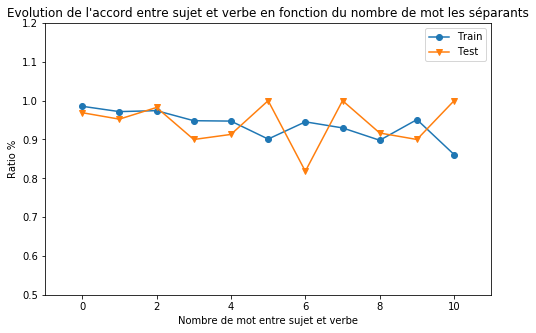

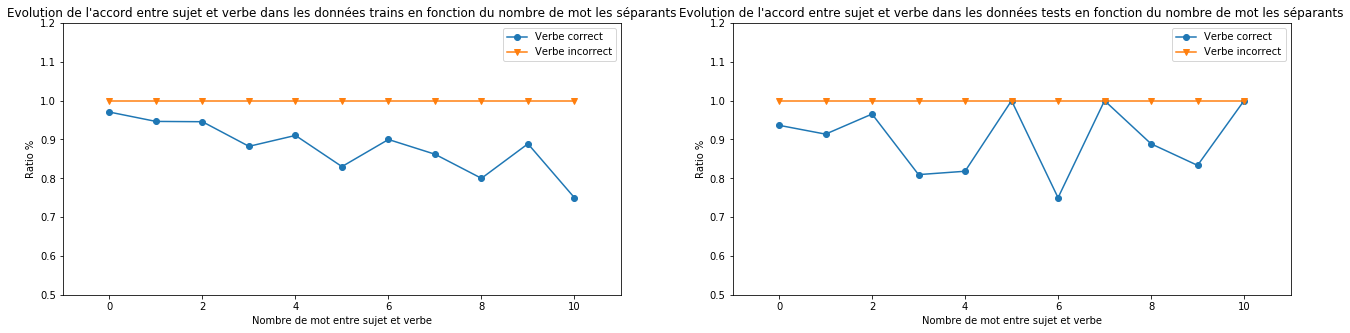

In [123]:
nom_entre=[0,1,2,3,4,5,6,7,8,9,10]

plt.figure(figsize=(8,5))
plt.plot(nom_entre,di_train,marker='o',label="Train")
plt.plot(nom_entre,di_test,marker='v',label="Test")
plt.xlabel("Nombre de mot entre sujet et verbe")
plt.ylabel('Ratio %')
plt.title("Evolution de l'accord entre sujet et verbe en fonction du nombre de mot les séparants")
plt.ylim(0.5,1.2)
plt.xlim(-1,11)
plt.legend()
plt.show

plt.figure(figsize=(22,5))
plt.subplot(121)
plt.plot(nom_entre,di_train_v,marker='o',label="Verbe correct")
plt.plot(nom_entre,di_train_f,marker='v',label="Verbe incorrect")
plt.xlabel("Nombre de mot entre sujet et verbe")
plt.ylabel('Ratio %')
plt.title("Evolution de l'accord entre sujet et verbe dans les données trains en fonction du nombre de mot les séparants")
plt.ylim(0.5,1.2)
plt.xlim(-1,11)
plt.legend()

plt.subplot(122)
plt.plot(nom_entre,di_test_v,marker='o',label="Verbe correct")
plt.plot(nom_entre,di_test_f,marker='v',label="Verbe incorrect")
plt.xlabel("Nombre de mot entre sujet et verbe")
plt.ylabel('Ratio %')
plt.title("Evolution de l'accord entre sujet et verbe dans les données tests en fonction du nombre de mot les séparants")
plt.ylim(0.5,1.2)
plt.xlim(-1,11)
plt.legend()
plt.show()

In [124]:
def matrice(x_t,y_t):
  mat=[]
  for i in range(4):
    lin = [0]*4
    mat.append(lin)
    lin = []
  
  l = model.predict(x_t)
  for j in range(len(l)):
    for k in range(len(l[j])):
      if y_t[j][k][1] == 1 or y_t[j][k][2] == 1:
        abci = argmax(y_t[j][k])  
        ordo = argmax(l[j][k])
        mat[abci][ordo]+=1
  mat = np.array(mat).reshape (4,4)
  return(mat)
 
matrice_confusion_tr = matrice(x_train, y_train)
print(matrice_confusion_tr)
matrice_confusion_te = matrice(x_test, y_test)
print(matrice_confusion_te)
    

[[   0    0    0    0]
 [   3 1478   76    0]
 [   3   36 1474    0]
 [   0    0    0    0]]
[[  0   0   0   0]
 [  2 252  22   0]
 [  1   5 280   0]
 [  0   0   0   0]]
